In [60]:
import pandas as pd

from ovr import GenerateSimpleBinaryClassification, GenerateWeakLabels, GenerateNaiveCosDistanceClusteringLabels, GenerateDangerMagnitudes
from NN import DangerMagnitudeNN

from sklearn.preprocessing import MinMaxScaler

from transformers import AutoTokenizer, AutoModel

import torch

test_data = pd.DataFrame({
    'PNT_NM': [
        "Fall Protection", 
        "Health Hazards", 
        "Ladder Safety", 
        "Equipment Operation", 
        "Rigging Safety", 
        "Heavy Equipment Safety", 
        "Electrical Safety", 
        "Slips, Trips, and Falls", 
        "Electrical Clearance", 
        "Work Zone Safety"
    ],
    'QUALIFIER_TXT': [
        "Improper fall protection use", 
        "Exposure to disease vectors", 
        "Unstable ladder placement", 
        "Unsafe equipment positioning", 
        "Rigging failure during hoist", 
        "Heavy equipment sliding", 
        "Lack of proper arc flash PPE", 
        "Hazardous object on walkway", 
        "Proximity to live electrical lines", 
        "Step into live traffic zone"
    ],
    'PNT_ATRISKNOTES_TX': [
        "An employee was on the top of a de-energized transformer at 25 feet of height with a proper fall arrest system. While working, she tripped on a lifting lug, falling within 2 feet from an unguarded edge. When the employee landed, she sprained her wrist.",
        "An employee contracted West Nile Virus after being bitten by a mosquito while at work in a boggy area. Because of the exposure, the employee was unconscious and paralyzed for a two-week period.",
        "An employee was working alone and placed an extension ladder against the wall. When he reached 10 feet of height, the ladder feet slid out and he fell with the ladder to the floor. The employee was taken to the hospital for a bruise to his right leg and remained off duty for three days.",
        "A crew was closing a 7-ton door on a coal crusher. As the door was lowered, an observer noticed that the jack was not positioned correctly and could tip. The observer also noted that workers were nearby, within 4 feet of the jack.",
        "Workers were hoisting beams and steel onto a scaffold. A certified mechanic operated an air hoist to lift the beam. As the lift was performed, the rigging was caught under an adjacent beam. Under the increasing tension, the cable snapped and struck a second employee in the leg, fully fracturing his femur. An investigation indicated that the rigging was not properly inspected before the lift.",
        "A dozer was operating on a pet coke pile and slid down an embankment onto the cab after encountering a void in the pile. The operator was wearing his seat belt, and the roll cage kept the cab from crushing. No workers or machinery were nearby, and no injuries were sustained.",
        "A master electrician was called to work on a new 480-volt service line in a commercial building. When working on the meter cabinet, the master electrician had to position himself awkwardly between the cabinet and a standpipe. He was not wearing an arc-rated face shield, balaclava, or proper gloves. During the work, an arc flash occurred, causing third-degree burns to his face.",
        "An employee was descending a staircase and when stepping down from the last step she rolled her ankle on an extension cord on the floor. She suffered a torn ligament and a broken ankle that resulted in persistent pain for more than a year.",
        "A crew was working near a sedimentation pond on a rainy day. The boom of the trac-hoe was within 3 feet of a live 12kV line running across the road. No contact was made because a worker intervened and communicated with the operator.",
        "A crew was working in a busy street to repair a cable fault. During the work, the journeyman took a step back from the truck outside of the protected work zone into oncoming traffic. A driver slammed on his brakes and stopped within one foot of the journeyman. No injuries were sustained."
    ],
    'PNT_ATRISKFOLWUPNTS_TX': ["NA"] * 10  # No follow-up notes for all test cases
}, index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

test_data.head()

,PNT_NM,QUALIFIER_TXT,PNT_ATRISKNOTES_TX,PNT_ATRISKFOLWUPNTS_TX
1,Fall Protection,Improper fall protection use,An employee was on the top of a de-energized t...,NA
2,Health Hazards,Exposure to disease vectors,An employee contracted West Nile Virus after b...,NA
3,Ladder Safety,Unstable ladder placement,An employee was working alone and placed an ex...,NA
4,Equipment Operation,Unsafe equipment positioning,A crew was closing a 7-ton door on a coal crus...,NA
5,Rigging Safety,Rigging failure during hoist,Workers were hoisting beams and steel onto a s...,NA


In [61]:
df = test_data

In [62]:
MULTISHOT = {
    """
    PNT_NM: Climbing - Procedures
    QUALIFIER_TXT: Was a drop zone established, and clearly marked?
    PNT_ATRISKNOTES_TX: Workers were hoisting beams and steel onto a scaffold. A certified mechanic operated an air hoist to lift the beam. As the lift was performed, the rigging was caught under an adjacent beam. Under the increasing tension, the cable snapped and struck a second employee in the leg, fully fracturing his femur. An investigation indicated that the rigging was not properly inspected before the lift.
    PNT_ATRISKFOLWUPNTS_TX: NA
    """: "9",
    """
    PNT_NM: Housekeeping - Generation
    QUALIFIER_TXT: Job site hazards, Tripping Hazards
    PNT_ATRISKNOTES_TX: An employee was descending a staircase and when stepping down from the last step she rolled her
    ankle on an extension cord on the floor. She suffered a torn ligament and a broken ankle that resulted in
    persistent pain for more than a year.
    PNT_ATRISKFOLWUPNTS_TX: NA 
    """: "7",
    """
    PNT_NM: Workplace Conditions Addressed
    QUALIFIER_TXT: Voltage being worked discussed
    PNT_ATRISKNOTES_TX: A crew was working near a sedimentation pond on a rainy day. The boom of the trac-hoe was within 3
    feet of a live 12kV line running across the road. No contact was made because a worker intervened and
    communicated with the operator.
    PNT_ATRISKFOLWUPNTS_TX: NA
    """: "4",
    """
    PNT_NM: Did you recognize additional slip, trip, or fall hazards that had not already been recognized and mitigated? If so, please select or describe these hazards in the At-Risk notes.
    QUALIFIER_TXT: Awareness of environment
    PNT_ATRISKNOTES_TX: [NAME] was working a near by cliff that had about a 20' drop off, crew didn't discuss as a hazard on briefing, i discussed with GF and he told the foreman to make the corrections and place something out there to give crews a visual.
    PNT_ATRISKFOLWUPNTS_TX: NA
    """: "6",
    """
    PNT_NM: PPE
    QUALIFIER_TXT: Side Shields adequate
    PNT_ATRISKNOTES_TX: Emplolyee was witnessed without side shields. Supervosor was informed so he couldd coach his employee.,
    PNT_ATRISKFOLWUPNTS_TX: NA
    """: "3",
    """
    PNT_NM: PPE
    QUALIFIER_TXT: Other - PPE, Safety glasses adequate
    PNT_ATRISKNOTES_TX: Employee operating Digger [NAME] not wearing safety glasses. Two not wearing correct safety glasses. One wearing safety glasses without side shields. One employee marking and drilling pole without work gloves.
    PNT_ATRISKFOLWUPNTS_TX: NA
    """: "5",
    """
    PNT_NM: 15) If new hazards were identified, or if conditions changed since the original briefing, were they documented?
    QUALIFIER_TXT: [Notes Required for At-Risk Conditions]
    PNT_ATRISKNOTES_TX: The crew was using a cart / gator too move scaffolding material later in the day and one of the guy was not wearing a seat belt, I stopped him and explain to him that he needed to wear the seatbelt at all times.
    PNT_ATRISKFOLWUPNTS_TX: NA
    """: "7",
}

In [63]:
GenerateWeakLabels(df=df)
GenerateNaiveCosDistanceClusteringLabels(df=df)
GenerateDangerMagnitudes(df=df, shot_examples=MULTISHOT)
GenerateSimpleBinaryClassification(df=df, col_name='HIS', class_def="If a High-Energy Criteria is present, output a 1. High Energy Criteria: Suspended Loads: Loads greater than 500 lbs lifted more than 1 foot off the ground. Elevation: Any height exceeding 4 feet, considering the average weight of a human (over 150 lbs). Mobile Equipment: Most mobile equipment, including motor vehicles, exceeds the high-energy threshold when in motion from the perspective of a worker on foot. Work Zone Traffic: An incident occurs if a vehicle departs its intended path within 6 feet of an exposed employee or if an employee enters the traffic pattern. Motor Vehicle Speed: An estimate of 30 miles per hour is considered the high-energy threshold for serious or fatal crashes. Mechanical Energy: Heavy rotating equipment beyond powered hand tools typically exceeds the high-energy threshold. Temperature: Exposure to substances at or above 150 degrees Fahrenheit can cause third-degree burns if contacted for 2 seconds or more. Any release of steam or combustion materials (e.g., paper burning at approximately 700 degrees Fahrenheit) exceeds the high-energy threshold. Explosions: Any incident described as an explosion exceeds the high-energy threshold. Unsupported Soil: Soil in a trench or excavation exceeding 5 feet of height, with pressure increasing approximately 40 pounds per square foot for each foot of depth. Electrical Energy: Voltage equal to or exceeding 50 volts can result in serious injury or death. Any arc flash also exceeds the high-energy threshold. Toxic Chemicals or Radiation: Use IDLH (Immediately Dangerous to Life or Health) values from the CDC and consider: Oxygen (O2) levels below 16% Corrosive chemical exposures (pH <2 or >12.5) Additional Considerations: If a situation does not fit any of the above criteria but encompasses potential energy: Estimate the weight in pounds (lbs) and height in feet (ft). If height is greater than 503.1 × weight − 0.99 503.1×weight −0.99 , it can be classified as high energy. If it encompasses kinetic energy: Estimate the weight in pounds (lbs) and speed in miles per hour (mph). If speed is greater than 𝑦 = 182.71 × weight − 0.68 , it can be classified as high energy.")
GenerateSimpleBinaryClassification(df=df, col_name='HII', class_def="If a High-Energy Incident is present, output a 1. High-Energy Incident: A high-energy incident is defined as an occurrence where: A high-energy source is released, changing state and becoming hazardous in the work environment The energy source must be no longer contained or under the control of the worker. The worker must have either: Contact: direct transmission of high energy to the human body. Proximity: within 6 feet of the energy source with unrestricted egress, or any distance in confined spaces or situations where escape is restricted.")
GenerateSimpleBinaryClassification(df=df, col_name='IS', class_def="If there is a severe injury sustained in the data, output a 1.")
GenerateSimpleBinaryClassification(df=df, col_name='NDC', class_def="If there is NO Mention of installed safety measures such as Machine guarding, Hard physical barriers, Fall protection systems, Covers or shield, output a 1")

df['ovr_danger'] = (df['weak_label'] / 4) + (df['cos_cluster_label'] / 4) + (df['danger_magnitude'] / 5) + (df['HII'] / 4) + (df['IS'] / 4) + (df['NDC'] / 4) + (df['HIS'] / 4)

# Note: would need to take MinMaxScalar of whole training dataset for new dataset, just creating a new object here for simplicity.
scaler = MinMaxScaler()
df['ovr_danger'] = scaler.fit_transform(df[['ovr_danger']])

100%|██████████| 10/10 [00:00<00:00, 2093.38it/s]
/Users/jacktaylor2/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
10it [00:08,  1.21it/s]
10it [00:05,  1.79it/s]
10it [00:03,  2.71it/s]
10it [00:03,  2.85it/s]
10it [00:03,  2.81it/s]


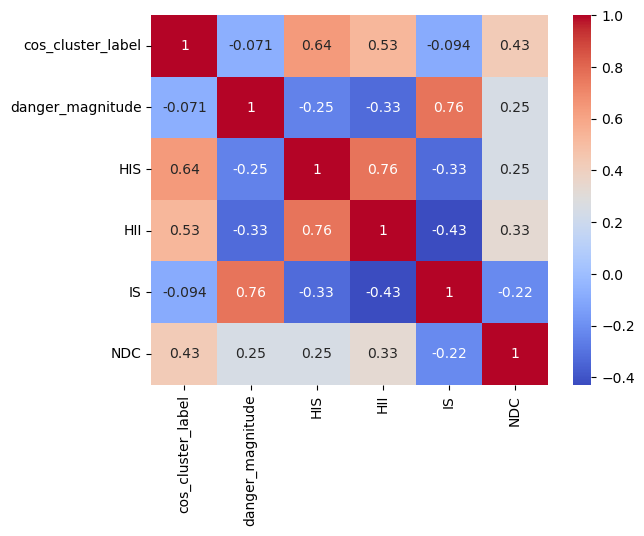

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your DataFrame 'df'
corr_matrix = df[['cos_cluster_label', 'danger_magnitude', 'HIS', 'HII', 'IS', 'NDC']].corr()

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [65]:
test_data

,PNT_NM,QUALIFIER_TXT,PNT_ATRISKNOTES_TX,PNT_ATRISKFOLWUPNTS_TX,weak_label,report,cos_cluster_label,danger_magnitude,HIS,HII,IS,NDC,ovr_danger
1,Fall Protection,Improper fall protection use,An employee was on the top of a de-energized t...,NA,3,Fall ProtectionImproper fall protection useAn ...,2,9,1,1,1,0,1.000000
2,Health Hazards,Exposure to disease vectors,An employee contracted West Nile Virus after b...,NA,1,Health HazardsExposure to disease vectorsAn em...,0,9,0,0,1,0,0.000000
3,Ladder Safety,Unstable ladder placement,An employee was working alone and placed an ex...,NA,0,Ladder SafetyUnstable ladder placementAn emplo...,2,9,1,0,1,0,0.333333
4,Equipment Operation,Unsafe equipment positioning,A crew was closing a 7-ton door on a coal crus...,NA,1,Equipment OperationUnsafe equipment positionin...,2,9,1,1,1,0,0.666667
5,Rigging Safety,Rigging failure during hoist,Workers were hoisting beams and steel onto a s...,NA,1,Rigging SafetyRigging failure during hoistWork...,2,9,1,1,1,0,0.666667
6,Heavy Equipment Safety,Heavy equipment sliding,A dozer was operating on a pet coke pile and s...,NA,0,Heavy Equipment SafetyHeavy equipment slidingA...,2,8,1,1,0,0,0.200000
7,Electrical Safety,Lack of proper arc flash PPE,A master electrician was called to work on a n...,NA,0,Electrical SafetyLack of proper arc flash PPEA...,3,9,1,1,1,1,0.833333
8,"Slips, Trips, and Falls",Hazardous object on walkway,An employee was descending a staircase and whe...,NA,1,"Slips, Trips, and FallsHazardous object on wal...",2,9,0,0,1,0,0.333333
9,Electrical Clearance,Proximity to live electrical lines,A crew was working near a sedimentation pond o...,NA,0,Electrical ClearanceProximity to live electric...,2,8,1,1,0,0,0.200000
10,Work Zone Safety,Step into live traffic zone,A crew was working in a busy street to repair ...,NA,0,Work Zone SafetyStep into live traffic zoneA c...,2,9,1,1,0,1,0.500000


In [66]:
model = DangerMagnitudeNN()

model.load_state_dict(torch.load('danger_magnitude_model.pth'))

model.eval()

/var/folders/1h/mw4kschx1jjdmd14bjl9nv4r0000gn/T/ipykernel_10069/569384898.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('danger_magni

DangerMagnitudeNN(
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc_proj): Linear(in_features=384, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [67]:
df['report'] = df['PNT_NM'] + df['QUALIFIER_TXT'] + df['PNT_ATRISKNOTES_TX'] + df['PNT_ATRISKFOLWUPNTS_TX']

reports = df['report'].values
danger_magnitudes = df['ovr_danger'].values

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = AutoModel.from_pretrained(model_name)

def get_embeddings(reports):
    inputs = tokenizer(reports.tolist(), padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        embeddings = transformer_model(**inputs).last_hidden_state[:, 0, :]
    return embeddings.numpy()

embeddings = get_embeddings(reports)

X = torch.tensor(embeddings, dtype=torch.float32)
y = torch.tensor(danger_magnitudes, dtype=torch.float32) 

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X = X.to(device)

with torch.no_grad():
    predictions = model(X)

predictions = predictions.cpu().numpy()

predictions

array([[0.6880238 ],
       [0.6256441 ],
       [0.44461137],
       [0.5880087 ],
       [0.46383584],
       [0.43973893],
       [0.41881758],
       [0.34986484],
       [0.4120042 ],
       [0.5046806 ]], dtype=float32)